# Sketch2Fruits
## Turn your sketches into colorful fruits images

<br>
<br>
This project aims to develop a model based on convolutional networks, capable of transforming the minimalist sketch of a fruit into a realistic image with appropriate colors and textures.  

To achieve this, the ingredients we are going to use are the following:

* Pictures of some fruits from the web: just **one picture per class** (we will use data augmentation to fix lack of images)
* **OpenCV** to extract countours from pictures
* **Keras** (tensorflow) to build our network
* An **autoencoder** approach with **skip connections**

The following image describes the network architecture that best fits the data:
<br>
<br>
<br>

![Architecture](images/network_architecture.svg)
<br>
<br>

Let's import all we need:

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Add, Input
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from ipywidgets.widgets import IntSlider, interactive_output, VBox, HBox
import time

And get images data:

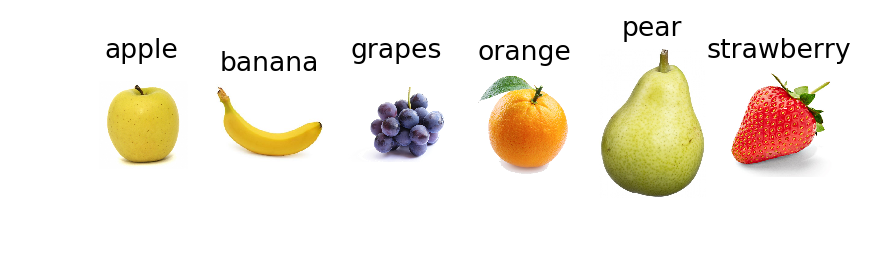

In [2]:
original_images = []
labels = []
for file_ in os.listdir('data/'):
    original_images.append(cv2.cvtColor(cv2.imread('data/'+file_), cv2.COLOR_BGRA2RGB))
    labels.append(file_.split('.')[0])
fig = plt.figure(dpi=160)
i = 1
for img, label in zip(original_images, labels):
    fig.add_subplot(1,len(original_images), i)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    i += 1

Now that we have our six pictures of apple, banana, grapes, orange, pear and strawberry; we need to write down some useful functions that will help us make some image preprocessing.

In [3]:
# Sketcher: tranform images into drawing
# OpenCV Utils:

def blurring(img, kernel):
    x, y = kernel
    img = cv2.blur(img, (x,y))
    return img

def resizing(img, size):
    x, y = size
    img = cv2.resize(img, (x,y))
    return img

def dilating(img, kernel):
    x,y = kernel
    img = cv2.dilate(img, np.ones((x,y), dtype='uint8'), 10)
    return img

def eroding(img, kernel):
    x,y = kernel
    img = cv2.erode(img, np.ones((x,y), dtype='uint8'), 10)
    return img

def canning(img, t1, t2):
    img = cv2.Canny(img, t1, t2, 7)
    return img

def sketcher(img, blur_kernel, size, canny_t1, canny_t2):
#     img[img > 250] = 255
    xb, yb = blur_kernel
    xs, ys = size
    img = canning(resizing(blurring(img, [xb, yb]), [xs, ys]), canny_t1, canny_t2)
    img = np.array(img, dtype='float')/np.max(np.array(img, dtype='float'))
    return img

def preprocess_output(img, size):
    x, y = size
    img = np.array(cv2.resize(img, (x,y)), dtype='float')
    img = img/np.max(img)
    return img

Let's extract the countours for each class image. To do this, we use OpenCV previous functions and the jupyter widgets, in order to enable a more comfortable and interactive preprocessing.
The operations are the following:

1. **Blur**: it decreases image noise,
2. **Resize**: resizing to standard dimensions for all classes,
3. **Canny Detector**: it extracts the contours by setting some parameters,
4. **Dilation**: it increases width of the contours,
5. **Erosion**: it makes contours thinner.

All the process:

![preprocessing](images/preprocessing.png)

The use of Jupyter Widgets:

![calibration](images/calibration.gif)

In [47]:
from cv_params import *

param_dict = {}
fruits = []
for label in labels:
    fruits.append(IntSlider(min=100,max=800, value=cv_dictionary[label+'_size'], step=50, description=label+'_size'))
    fruits.append(IntSlider(min=1,max=20, value=cv_dictionary[label+'_blur'],step=1, description=label+'_blur'))
    fruits.append(IntSlider(min=10,max=255, value=cv_dictionary[label+'_c1'],step=10, description=label+'_c1'))
    fruits.append(IntSlider(min=10,max=255, value=cv_dictionary[label+'_c2'],step=10, description=label+'_c2'))
    fruits.append(IntSlider(min=1,max=20, value=cv_dictionary[label+'_dil'],step=1, description=label+'_dil'))
    fruits.append(IntSlider(min=1,max=20, value=cv_dictionary[label+'_ero'],step=1, description=label+'_ero'))
inp_ = VBox(fruits)
params = {}
for wid in fruits:
    params[wid.description] = wid

def f(**params):
    global labels
    global param_dict
    for label in labels:
        param_dict[label] = {}
    for name, param in params.items():
        param_dict[name.split('_')[0]][name.split('_')[1]] = param
    fig, axes = plt.subplots(nrows=len(labels), ncols=1, dpi=350)
    for ax, label, i in zip(axes, labels, range(0,len(labels))):
        size = param_dict[label]['size']
        blur_ = param_dict[label]['blur']
        c1 = param_dict[label]['c1']
        c2 = param_dict[label]['c2']
        dil = param_dict[label]['dil']
        ero = param_dict[label]['ero']
        img = np.array(cv2.cvtColor(resizing(original_images[i], [size,size]), cv2.COLOR_BGRA2BGR), dtype='uint8')
        ax.imshow(eroding(dilating(sketcher(img, [blur_,blur_], [img.shape[1],img.shape[0]],c1,c2), [dil,dil]), [ero,ero]))
        ax.set_axis_off()
    plt.show()
    return param_dict

out = interactive_output(f, params)

display(HBox([inp_, out]))


The following paragraph applies the previously defined transformations to the original images:

In [5]:
# generating resized pictures and sketches:

pictures = []
sketches = []
for label, i in zip(labels, range(0,len(labels))):
    size = param_dict[label]['size']
    blur_ = param_dict[label]['blur']
    c1 = param_dict[label]['c1']
    c2 = param_dict[label]['c2']
    dil = param_dict[label]['dil']
    ero = param_dict[label]['ero']
    img = np.array(cv2.cvtColor(resizing(original_images[i], [size,size]), cv2.COLOR_BGRA2BGR), dtype='uint8')
    sk = eroding(dilating(sketcher(img, [blur_,blur_], [img.shape[1],img.shape[0]],c1,c2), [dil,dil]), [ero,ero])
    sketches.append(sk)
    pictures.append(img)

Now it's time to make some Data Augmentation because we have only one sample per class. Data augmentation enriches our dataset with a thousands of different images generated from the original ones. The techniques that are used are the following:

* **Rescaling**: zoom in or zoom out of the original image, preserving the original size with padding or cropping
* **Random decentralization**: the rescaled image is positioned randomly within the padded image
* **Flipping**: decentralized image is then flipped around a random axis
* **Rotation**: random rotation is applied


![augmentation](images/dataaugmentation.png)

The same pipeline is applied to relative sketches.

In [6]:
# Data Augmentation Functions

def augment_image(img, sketch, zooms=10, replication=2, size=100, from_size=50):
    assert zooms > 1
    assert type(img) == np.ndarray
    assert type(sketch) == np.ndarray
    if img.dtype == 'int':
        img = np.array(img, dtype='float')
        print("Dtype Adjustment...")
        clear_output(wait=True)
        time.sleep(0.4)
    if sketch.dtype == 'int':
        sketch = np.array(sketch, dtype='float')
        print("Dtype Adjustment...")
        clear_output(wait=True)
        time.sleep(0.4)
    if np.max(sketch) > 1.0:
        sketch = sketch/np.max(sketch)
        print("Normalization...")
        clear_output(wait=True)
        time.sleep(0.4)
    if np.max(img) > 1.0:
        img = img/np.max(img)
        print("Normalization...")
        clear_output(wait=True)
        time.sleep(0.4)
    if len(img.shape) < 3:
        img = np.concatenate([img.reshape(img.shape[0], img.shape[1], 1),
                          img.reshape(img.shape[0], img.shape[1], 1),
                          img.reshape(img.shape[0], img.shape[1], 1)], axis=2)
    if img.shape[2] == 1:
        img = np.concatenate([img, img, img], axis=2)
    # standard resizing:
    res_img = cv2.resize(img, (size,size), cv2.INTER_LINEAR)
    res_sketch = cv2.resize(sketch, (size,size), cv2.INTER_LINEAR)
    sizing_steps = np.arange(from_size, size, int((size-from_size)/float(zooms)))
    padding_steps = ((size**2)/sizing_steps) - size
    # print(padding_steps)
    color = [1.0, 1.0, 1.0]
    def random_repartition(pad_value):
        random_num = 1
        while random_num < 2:
            random_num = int(np.random.rand(1)[0]*pad_value)
            x = int(random_num)
            y = int(pad_value - int(random_num))
        return x,y
    total_collection = []
    total_sketch_collection = []
    for pad in padding_steps:
    # rotation & mirroring
        for rotation_mode in [None, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]:
            for flip_mode in [None, 0,1,-1]:
                if (rotation_mode is None) and (flip_mode is None):
                    fliprotate = np.array(res_img)
                    fliprotate_sketch = np.array(res_sketch)
                if (rotation_mode is None) and (flip_mode is not None):
                    fliprotate = cv2.flip(res_img, flip_mode)
                    fliprotate_sketch = cv2.flip(res_sketch, flip_mode)
                if (rotation_mode is not None) and (flip_mode is None):
                    fliprotate = cv2.rotate(res_img, rotation_mode)
                    fliprotate_sketch = cv2.rotate(res_sketch, rotation_mode)
                if (rotation_mode is not None) and (flip_mode is not None):
                    fliprotate = cv2.flip(cv2.rotate(res_img, rotation_mode), flip_mode)
                    fliprotate_sketch = cv2.flip(cv2.rotate(res_sketch, rotation_mode), flip_mode)
                for _ in range(0,replication):
                    top, bottom = random_repartition(pad)
                    left, right = random_repartition(pad)
                    #print(top, bottom, left, right)
                    padded = cv2.copyMakeBorder(fliprotate, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
                    padded_sketch = cv2.copyMakeBorder(fliprotate_sketch, top, bottom, left, right,
                                                       cv2.BORDER_CONSTANT,value=[0.0,0.0,0.0])
                    #print(padded.shape)
                    res_padded = cv2.resize(padded, (size,size), cv2.INTER_LINEAR)
                    res_padded_sketch = cv2.resize(padded_sketch, (size,size), cv2.INTER_LINEAR)
                    res_padded = res_padded/np.max(res_padded)
                    res_padded_sketch = res_padded_sketch/np.max(res_padded_sketch)
                    res_padded_sketch[res_padded_sketch > 0.5] = 1.0
                    res_padded_sketch[res_padded_sketch <= 0.5] = 0.0
                    if np.max(res_padded) != 0:
                        total_collection.append(res_padded)
                        total_sketch_collection.append(res_padded_sketch)
    return total_collection, total_sketch_collection

def augment_collection(collection, sketches, zooms=10, replication=2, size=100, from_size=50):
    total_collection = []
    total_sketch_collection = []
    for img, skt in zip(collection, sketches):
        coll, sk_coll = augment_image(img, skt, zooms, replication, size, from_size)
        total_collection = total_collection + coll
        total_sketch_collection = total_sketch_collection + sk_coll
    return total_collection, total_sketch_collection


Let's apply data augmentation function and see what happens:

Augmented Images:  9216
Samples:


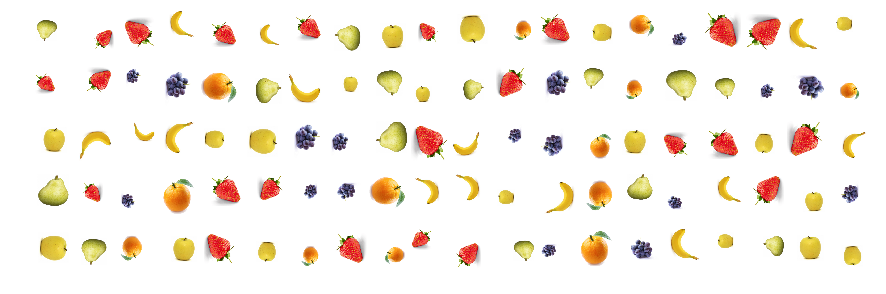

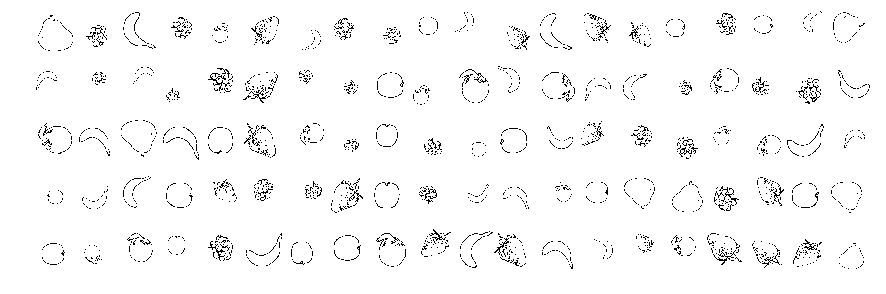

In [7]:
augmented, augmented_sketches = augment_collection(pictures, sketches, zooms=4, replication=24, size=200, from_size=100)

print("Augmented Images: ", len(augmented)) 
print("Samples:") 
fig = plt.figure(figsize=[15,5])
i = 1
for index in np.random.choice(range(0,len(augmented)), 100):
    fig.add_subplot(5,20,i)
    plt.imshow(augmented[index])
    plt.axis('off')
    i += 1
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
fig = plt.figure(figsize=[15,5])
i = 1
for index in np.random.choice(range(0,len(augmented_sketches)), 100):
    fig.add_subplot(5,20,i)
    plt.imshow(1-augmented_sketches[index], cmap='gray')
    plt.axis('off')
    i += 1
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Now that we gather all the fruits on earth.. we can start building our network structure:


In [10]:
input_ = Input(shape=(200,200,1))
conv0 = Conv2D(6, (3,3), activation='relu', padding='same', data_format='channels_last')(input_)
pool0 = MaxPooling2D((2,2), padding='same')(conv0)
conv1 = Conv2D(6, (3,3), activation='relu', padding='same', data_format='channels_last')(pool0)
pool1 = MaxPooling2D((2,2), padding='same')(conv1)
skip0 = pool1
conv2 = Conv2D(16, (3,3), activation='relu', padding='same', data_format='channels_last')(pool1)
pool2 = MaxPooling2D((2,2), padding='same')(conv2)
skip1 = pool2
conv3 = Conv2D(32, (3,3), activation='relu', padding='same', data_format='channels_last')(pool2)
pool3 = MaxPooling2D((5,5), padding='same')(conv3)
skip2 = pool3
conv4 = Conv2D(52, (3,3), activation='relu', padding='same', data_format='channels_last')(pool3)
pool4 = MaxPooling2D((5,5), padding='same')(conv4)
conv4 = Conv2D(52, (3,3), activation='relu', padding='same', data_format='channels_last')(pool3)
encoded = Conv2D(10, (1,1),activation='sigmoid', padding='same', data_format='channels_last')(conv4)
deconv1 = Conv2DTranspose(52, (3,3),activation='sigmoid', padding='same', data_format='channels_last')(encoded)
deconv2 = Conv2DTranspose(32, (3,3),activation='sigmoid', padding='same', data_format='channels_last')(deconv1)
merge0 = BatchNormalization()(Add()([deconv2, skip2]))
up2 = UpSampling2D((5,5))(merge0)
deconv3 = Conv2DTranspose(16, (3,3), activation='sigmoid', padding='same', data_format='channels_last')(up2)
merge1 = BatchNormalization()(Add()([deconv3, skip1]))
up3 = UpSampling2D((2,2))(merge1)
deconv4 = Conv2DTranspose(6, (3,3), activation='sigmoid', padding='same', data_format='channels_last')(up3)
merge2 = BatchNormalization()(Add()([deconv4, skip0]))
up4 = UpSampling2D((2,2))(merge2)
deconv5 = Conv2DTranspose(6, (3,3), activation='sigmoid', padding='same', data_format='channels_last')(up4)
up5 = UpSampling2D((2,2))(deconv5)
output = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', data_format='channels_last')(up5)

model = Model(inputs=[input_], outputs=[output])

model.compile(loss='mae', optimizer='adam')
model.summary()

c:\users\giovanni nardini\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 6)  60          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 100, 100, 6)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 6)  330         max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_poolin

and setting up input and output tensors with proper shapes:  
<br>
<font size=4>X</font> `(n_images, image_width=200, image_height=200, channels=1)` --> Binary Image of Sketch  
<font size=4>y</font> `(n_images, image_width=200, image_height=200, channels=3)` --> Corresponding RGB image 

In [11]:
size = 200

X = []
y = []
for img, skt in zip(augmented, augmented_sketches):
    y.append(preprocess_output(img, [size,size]).reshape(1,size,size,3))
    X.append(preprocess_output(skt, [size,size]).reshape(1,size,size,1))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
print("X Shape:", X.shape)
print("y Shape:", y.shape)

X Shape: (9216, 200, 200, 1)
y Shape: (9216, 200, 200, 3)


It is very useful to monitor inference during training, expecially when dealing with images. For that reason we build a callback to visualize image prediction during training and after each epoch:

In [12]:
# callbacks to Images monitoring during training

class GetImage(Callback):
    def on_epoch_end(self, epoch, logs=None):
        global model
        global X
        global size
        global labels
        monitored = {}
        for label in labels:
            ind = int(float(X.shape[0])/float(len(labels)))*labels.index(label) + 10
            monitored[label] = ind
        fig = plt.figure(figsize=[16,6])
        i = 1
        for k,v in monitored.items():
            ax = fig.add_subplot(1,len(labels), i)
            test_img = X[v]
            pred = model.predict(test_img.reshape(1,size, size, 1)).reshape(size,size,3)
            ax.imshow(pred)
            ax.set_title(k)
            i += 1
        plt.show()
        clear_output(wait=True)
        time.sleep(3)


Let's train for 15 epochs with batch size equal to 5:

In [27]:
model.fit(X,y, batch_size=5, epochs=15, callbacks=[GetImage()], shuffle=True)

Now we can visualize the reconstructed image output by feeding our model with a sketch:

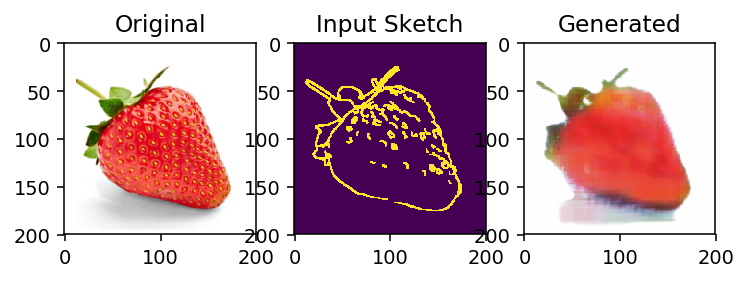

In [48]:
test_index = 8900
test_image = augmented[test_index]
input_image = augmented_sketches[test_index]
prediction = model.predict(input_image.reshape(1,size,size,1)).reshape(size,size,3)
fig = plt.figure(dpi=140)
fig.add_subplot(131)
plt.imshow(resizing(test_image, [size,size]))
plt.title('Original')
fig.add_subplot(132)
plt.imshow(input_image)
plt.title('Input Sketch')
fig.add_subplot(133)
plt.imshow(prediction)
plt.title('Generated')
plt.show()

Let's save the model architecture with its weights to make inference in the `draw_your_own.py` application!

In [ ]:
# type the model name:
model_name = 'sketch2fruits'

In [49]:
with open('models/'+model_name+'.json', 'w') as file_:
    file_.write(model.to_json())
model.save_weights('models/'+model_name+'.h5')